In [1]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import pickle
import threading
from IPython.display import clear_output
import time
import tokenizer
import os

In [ ]:
# exquisite acronym explanation (also sounds like lean):
# R - recurrent
# E - embedding
# A - approximation
# N - network

In [ ]:
# embeddings model
model_file = fr"./embedding_models/180vec_checkpt3.model"
embeddings_model = Word2Vec.load(model_file)

vector_size = embeddings_model.vector_size        # aka embedding dim 
window = embeddings_model.window                  # not important, scared to delete

# neural net settings
context_length = 36                               # tokens to consider
attn_heads = 18                                   # num attention heads per mechanism (per transformer block)
dropout_prob = 0.0                                # for dropout layers

# dataset
train_dataset_path = fr"./datasets/ultra_train.txt"
test_dataset_path = fr"./datasets/ultra_test.txt"

tokens_train = 1024# * 8 * 8 * 8 * 8# * 8# * 8 * 8 * 8
tokens_test = 1024# * 8 * 8

# training
train_epochs = 80
warmup_epochs = 4
optimizer_step_batches = 1

initial_warmup_lr =   0.0000001   * optimizer_step_batches
final_warmup_lr =     0.00003     * optimizer_step_batches
initial_train_lr =    0.00003     * optimizer_step_batches
final_train_lr =      0.000001    * optimizer_step_batches

class CosineSimilarityLoss(nn.Module):
    def __init__(self, reduction='mean'):
        super(CosineSimilarityLoss, self).__init__()
        self.reduction = reduction

    def forward(self, output, target):
        # Cosine similarity (F.cosine_similarity) returns similarity, so we use 1 - similarity as the loss
        cosine_sim = F.cosine_similarity(output, target, dim=1)
        loss = 1 - cosine_sim
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

loss = CosineSimilarityLoss()#nn.MSELoss()

train_optimizer = torch.optim.Adam
warmup_optimizer = torch.optim.Adam

train_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
warmup_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR

train_batch_size = int(1024 * 12)
test_batch_size = int(1024 * 12)
test_loop_epoch = 4

# plots
plot_graphs = True
plot_batches = 4
background_color = "#0c0220"
text_color =       "#06f8eb"
axis_color =       "#06f8eb"
train_loss_color = "#fca927"
test_loss_color =  "#fca927"
lr_color =         "#fca927"

# pytorch
run_device = torch.device("cuda")
storage_device = torch.device("cpu")
global_dtype = torch.float32

In [ ]:
class attention_mech(nn.Module):
    def __init__(self, vector_size=vector_size, attn_heads=attn_heads):
        super(attention_mech, self).__init__()
        # MultiheadAttention module
        self.multihead_attn = nn.MultiheadAttention(embed_dim=vector_size, num_heads=attn_heads)
        
        # Layer normalization
        self.norm = nn.LayerNorm(vector_size)

    def forward(self, x):
        # Prepare for multi-head attention (transpose to (sentence_len, batch_size, embedding_dim))
        x = x.transpose(0, 1)
        
        # Apply multi-head attention
        attn_output, attn_weights = self.multihead_attn(x, x, x)
        
        # Apply layer normalization to the attention output
        attn_output = self.norm(attn_output)
        
        # Transpose back to (batch_size, sentence_len, embedding_dim)
        output = attn_output.transpose(0, 1)
        
        return output, attn_weights

In [ ]:
class transformer_block_light(nn.Module):
    def __init__(self, vector_size=vector_size, dropout_prob=dropout_prob):
        super(transformer_block_light, self).__init__()
        
        self.attn = attention_mech()
        
        self.fc = nn.Linear(vector_size, vector_size)
        
        self.norm = nn.LayerNorm(vector_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, prev_block: torch.Tensor) -> torch.Tensor:
        attn_out, _ = self.attn(prev_block)
        
        x = self.norm(attn_out)
        
        x = self.dropout(x)
        
        # feedforward
        x = F.gelu(self.fc(x))
        
        return x

In [ ]:
class transformer_block_full(nn.Module):
    def __init__(self, context_length=context_length, vector_size=vector_size, dropout_prob=dropout_prob):
        super(transformer_block_full, self).__init__()
        
        self.attn = attention_mech()
        
        self.norm = nn.LayerNorm(vector_size)
        
        self.fc = nn.Linear(context_length * vector_size, context_length * vector_size)
        
        self.dropout = nn.Dropout(dropout_prob)
        
    def forward(self, prev_block: torch.Tensor) -> torch.Tensor:
        attn_out, _ = self.attn(prev_block)
        
        x = self.norm(attn_out)
        
        x = self.dropout(x)
        
        # feedforward
        x = x.flatten(start_dim=1)
        x = F.gelu(self.fc(x))
        x = x.view(x.shape[0], context_length, vector_size)
        
        return x

In [ ]:
class output_head(nn.Module):
    def __init__(self):
        super(output_head, self).__init__()
        
        self.attn = attention_mech()
        
        self.fc = nn.Linear(context_length * vector_size, vector_size)
        
        self.norm = nn.LayerNorm(vector_size)
        
    def forward(self, transformer_out: torch.Tensor) -> torch.Tensor:
        attn_out, _ = self.attn(transformer_out)
        
        x = self.norm(attn_out)
        
        x = x.view(x.shape[0], context_length * vector_size)
        
        x = F.tanh(self.fc(x))
        
        return x

In [ ]:
class REAN(nn.Module):
    def __init__(self):
        super(REAN, self).__init__()
        
        self.TL1 = transformer_block_light()
        self.TL2 = transformer_block_light()
        self.TL3 = transformer_block_light()
        
        self.TF1 = transformer_block_full()
        self.TF2 = transformer_block_full()
        self.TF3 = transformer_block_full()
        
        self.out_head = output_head()

    def forward(self, segment: torch.Tensor) -> torch.Tensor:
        res_connection = segment.clone()
        
        segment = self.TF1(segment)
        
        #segment = segment + res_connection
        
        segment = self.TF2(segment)
        
        #segment = segment + res_connection
        
        segment = self.TF3(segment)
        
        # Convert back to a single vector
        out_vector = self.out_head(segment)
        
        return out_vector

net = REAN()
net.to(global_dtype)
net.to(run_device)

train_optimizer = train_optimizer(net.parameters(), lr=initial_train_lr)
warmup_optimizer = warmup_optimizer(net.parameters(), lr=initial_warmup_lr)

train_scheduler = train_scheduler(train_optimizer, T_max=train_epochs, eta_min=final_train_lr)
warmup_scheduler = warmup_scheduler(warmup_optimizer, T_max=warmup_epochs, eta_min=final_warmup_lr)

In [ ]:
print(f"neural net weight: {sum(param.numel() * param.element_size() for param in net.parameters()) / (1024 ** 3):.4f}GB")

neural net weight: 0.4775GB


In [ ]:
def vectorize_sentence(sentence: list[str], model: Word2Vec=embeddings_model, default: int = 0) -> np.ndarray:
    """
    encodes all words in a given list to corresponding vectors in given model.
    words not found in the model will be given a vector with "default" value
    
    parameters:
        sentence (list): list of strings (tokenized sentence)
        model (Word2Vec): model to use when encoding
        default (int): fill vector with this value if word is not found in model
    
    returns:
        np.array: 2d array with dim1 = len(sentence) and dim2 = model.vector_size
    """
    
    # generate inital array with default values
    vectorized = np.ones((len(sentence), model.vector_size)) * default
    
    # loop over every word in list
    for current_word, current_word_idx in zip(sentence, range(len(sentence))):
        # only add correct values if word is in model, otherwise leave as default
        if current_word in model.wv:
            vectorized[current_word_idx] *= 0
            vectorized[current_word_idx] += model.wv[current_word]
    
    return vectorized

In [ ]:
def devectorize_sentence(vectorized_sentence: np.array, model: Word2Vec=embeddings_model) -> list:
    """
    decodes vectors into nearest word found in model
    
    parameters:
        vectorized_sentence (np.array): 2d arrat with vectors of words to be decoded
        model (Word2Vec): model to use when decoding
    
    returns:
        list: list of strings (words) whos vectors most closely match those provided
    """
    
    result = []
    
    # go over all words and find closest match in model
    for current_word in vectorized_sentence:
        result.append(model.wv.similar_by_vector(current_word)[0][0])
    
    return result

In [ ]:
def pad_or_truncate(suspected_tensor: torch.tensor, target_length: int, default: int=0) -> torch.Tensor:
    """
    pads or truncates a given tensor along dim 0 to target_length with "default" as padding
    
    parameters:
        suspected_tensor (torch.tensor): tensor to pad or truncate
        target_length (int): target length of tensor
        default (int): value to use for padding
    
    returns:
        torch.tensor: tensor of proper length no matter what
    """
    
    if len(suspected_tensor) < target_length:
        # pad
        suspected_tensor = torch.cat((torch.ones(target_length - len(suspected_tensor), suspected_tensor.shape[1], dtype=global_dtype, device=suspected_tensor.device) * default, suspected_tensor))
    else:
        # truncate
        suspected_tensor = suspected_tensor[-target_length:]
    
    return suspected_tensor

In [ ]:
def prepare_sentence_for_net(sentence: list[str], model: Word2Vec=embeddings_model, crop_to: int=context_length, flatten: bool = True, used_device: torch.device = run_device) -> torch.Tensor:
    """
    Turns a sentence (list of strings) into a tensor that can be fed directly into the network
    
    Parameters:
        sentence (list of str): sentence to be prepared
        model (Word2Vec): model to use when encoding sentence
        context_length (int): length of context to consider when encoding, should be same as network's
        flatten (bool): whether to flatten the tensor to fit into the first fc layer of the net
        used_device (torch.device): the device to use for the tensor
    
    Returns:
        torch.Tensor: tensor of proper length no matter what
    """
    # Encode sentence to numpy array
    vectorized = vectorize_sentence(sentence, model)
    
    # Directly create the tensor on the target device
    vectorized_tensor = torch.tensor(vectorized, dtype=global_dtype, device=used_device)
    
    # Pad or truncate
    vectorized_tensor = pad_or_truncate(vectorized_tensor, crop_to)
    
    if flatten:
        # Flatten to fit into the first fully connected layer of the net
        vectorized_tensor = vectorized_tensor.flatten()
    
    return vectorized_tensor

In [ ]:
def predict_word(current_segment: str, net: REAN=net, embeddings_model: Word2Vec=embeddings_model) -> str:
    """
    uses the net and the model to predict the next token to fit the given current_segment
    
    parameters:
        current_segment (str): prompt sentence
        net (REAN): net to use when predicting
        model (Word2Vec): embedding model to use when encoding sentence
    
    returns:
        str: predicted word
    """
    encoded_segment = prepare_sentence_for_net(current_segment, embeddings_model, context_length, flatten=False)
    
    # run sentence
    output = net(encoded_segment.unsqueeze(0))
    
    # add the net's vector to the end of the current segment
    target = output# + encoded_segment[-1]
    
    # decode most similar word to whatever net predicted
    predicted_word = embeddings_model.wv.similar_by_vector(target.detach().squeeze(0).cpu().numpy())[0][0]
    
    return predicted_word

In [ ]:
def predict_sequence(sentence: str, num_completions: int, net: REAN=net, embeddings_model: Word2Vec=embeddings_model) -> list:
    """
    predicts multiple words at the end of the given sentence
    
    parameters:
        sentence (str): sentence / prompt
        num_completions (int): number of tokens to predict
        net (REAN): net to use when predicting
        model (Word2Vec): embedding model to use when encoding sentence
    
    returns:
        list: list of words to be appended to given sentence
    """
    
    predicted_result = sentence
    
    for _ in tqdm(range(num_completions)):
        # give the network the full context to work with, while only collecting the predicted part into the result
        predicted_result += f"{predict_word(predicted_result, net=net, embeddings_model=embeddings_model)}"
    
    return predicted_result

In [ ]:
class REAN_dataset(Dataset):
    def pull_tokens(self, start_read_idx: int, requested_num_tokens: int):
        """
        function returns a requested number of tokens from the dataset file, starting at APPROXIMATLY the start_read_idx token.\n
        attempts to return full words as much as possible, example:\n
        NO:    this | is | a | sen (tence)\n
        YES:   this | is | a | sentence
        
        Args:
            start_read_idx (int): the APPROXIMATE token at which to start the reading (determined from the avarage token length in the tokenizer vocab)
            requested_num_tokens (int): how many tokens to return
        
        Returns:
            tokenized text (list of str): the tokens of the dataset from start_read_idx to start_read_idx + requested_num_tokens
            is EOF hit (bool): if the requested args were outside of the dataset's range
        """
        
        with open(self.path, errors="ignore") as self.dataset:
            self.dataset.seek(start_read_idx * tokenizer.average_token_length)
            
            # get an initial estimate to what text we will actually need
            self.buffer = self.dataset.read(requested_num_tokens * tokenizer.average_token_length)
            self.tokenized_buffer = tokenizer.tokenize_sentence(self.buffer)
            self.current_num_tokens = len(self.tokenized_buffer)
            
            # if the estimate we took is too small, we enlarge it character by character until its perfect
            while self.current_num_tokens < requested_num_tokens + 1:
                self.next_char = self.dataset.read(1)  # seperate variable to check EOF
                
                # check eof
                if not self.next_char:
                    print("pull_tokens(): eof was hit")
                    return self.tokenized_buffer[-requested_num_tokens - 1:][:-1], True
                
                self.buffer += self.next_char
                
                self.tokenized_buffer = tokenizer.tokenize_sentence(self.buffer)
                self.current_num_tokens = len(self.tokenized_buffer)
        
        # regardless of if the estimate is too long / short, return theproper amount of tokens, with the end snipped of, because it might be a half token
        return self.tokenized_buffer[-requested_num_tokens - 1:][:-1], False
    
    def construct_example(self, start_read_idx: int):
        """
        function to make a full datapoint, can be used as raw return for __getitem__()
        
        Args:
            start_read_idx (int): at which token to start making the example
        
        Returns:
            tokenized text (list of str): the tokens of the dataset from start_read_idx to start_read_idx + self.context_length
        """
        
        # pull neccesary amount of tokens for question / input and answer / output
        self.tokens, _ = self.pull_tokens(start_read_idx, self.context_length + 1)
        
        # encode the tokens to vectors (aka embeddings)
        self.vectorized_tokens = prepare_sentence_for_net(self.tokens, flatten=False, used_device=storage_device, crop_to=self.context_length + 1)
        
        # split into network input and expected output
        self.question = self.vectorized_tokens[:-1] # everythinbg up to last word
        self.answer = self.vectorized_tokens[-1] # last word itself
        
        return self.question, self.answer
    
    def get_size(self):
        """
        function to read thru the whole dataset, and report how many examples there are / if there are as many as the user requested
        
        Args:
            none, but uses self.num_tokens and self.context_length
        
        Returns:
            returns how many usable examples there are, for __len__()
        """
        
        with tqdm(total=self.num_examples, desc="Calculating Dataset Size", unit="example") as pbar:
            for self.current_check in range(self.num_examples):
                _, self.eof = self.pull_tokens(self.current_check, self.context_length)
                
                if self.eof:
                    print("The requested size is bigger than the .txt provided, so the dataset might be smaller than what you expected.")
                    break

                pbar.update(1)

        print(f"Requested num_examples: {self.num_examples}\nActual size found:      {self.current_check - 1}")
        
        return self.current_check - 1   # the -1 is just in case
    
    def __init__(self, path, num_examples, context_length, embeddings_model, verify_dataset_size=True):
        # transfer to object wide variables
        self.path = path
        self.context_length = context_length
        self.embeddings_model = embeddings_model
        self.num_examples = num_examples
        
        # get the size of the dataset txt file
        self.dataset_len = num_examples
        
        if verify_dataset_size:
            self.dataset_len = self.get_size()

    def __len__(self):
        return self.dataset_len
    
    def __getitem__(self, index):
        return self.construct_example(index)

In [ ]:
train_dataset = REAN_dataset(train_dataset_path, tokens_train, context_length, embeddings_model, verify_dataset_size=False)
test_dataset = REAN_dataset(test_dataset_path, tokens_test, context_length, embeddings_model, verify_dataset_size=False)

In [ ]:
# if num_workers arg is used
os.environ["TOKENIZERS_PARALLELISM"] = "false"

train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=True, num_workers=4)

In [ ]:
net.train()
clear_output()

In [ ]:
train_loss_graph = []
test_loss_graph = []
learning_rate_graph = []

100%|██████████| 4/4 [00:05<00:00,  1.11s/it]

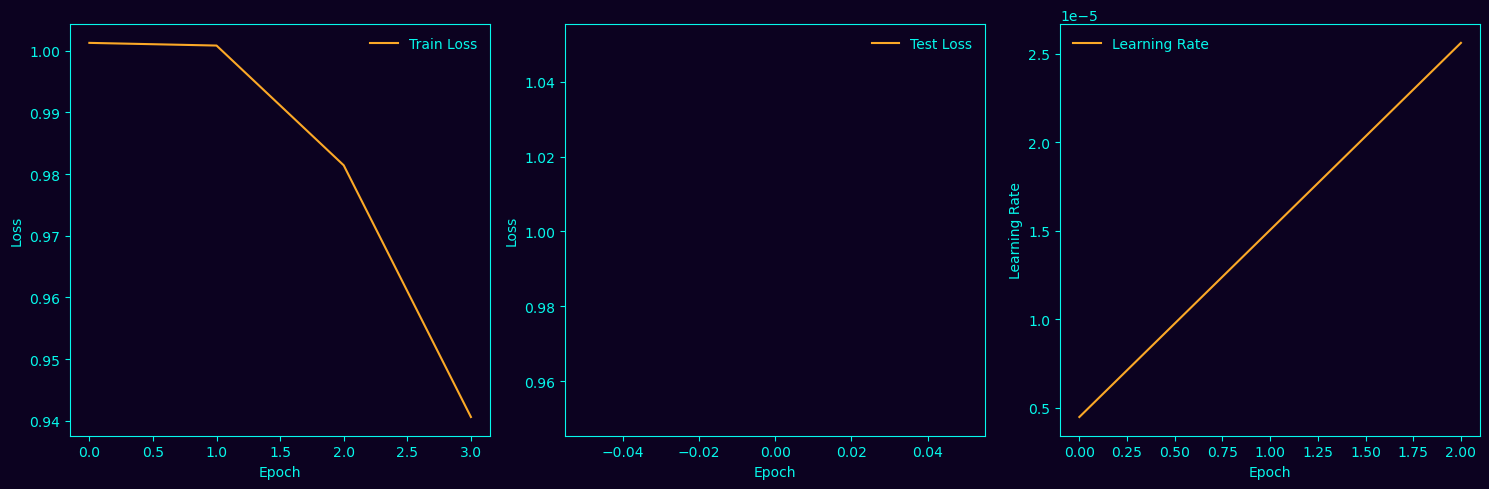

100%|██████████| 4/4 [00:05<00:00,  1.47s/it]


In [ ]:
with tqdm(total=warmup_epochs) as pbar:
    batch = 0
    
    for epoch in range(warmup_epochs):
        pbar.update(1)
        
        # training loop
        for current_segment, target in train_loader:
            batch += 1
            
            # move batch to gpu
            current_segment = current_segment.to(run_device)
            target = target.to(run_device)
            
            # train batch
            train_outputs = net(current_segment)
            train_loss_value = loss(train_outputs, target)
            train_loss_value.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            if batch % optimizer_step_batches == 0:
                warmup_optimizer.step()
                warmup_optimizer.zero_grad()
            
            # collect performance metrics
            train_loss_graph.append(train_loss_value.item())
            
            # plot everything
            if batch % plot_batches == 0:
                if plot_graphs:
                    clear_output(wait=True)
                    
                    pbar.refresh()
                    
                    plt.figure(figsize=(15, 5), facecolor=background_color)

                    # Plot training loss
                    ax1 = plt.subplot(1, 3, 1, facecolor=background_color)
                    plt.plot(train_loss_graph, label='Train Loss', color=train_loss_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Loss', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax1.spines['top'].set_color(axis_color)
                    ax1.spines['bottom'].set_color(axis_color)
                    ax1.spines['left'].set_color(axis_color)
                    ax1.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax1.tick_params(axis='x', colors=axis_color)
                    ax1.tick_params(axis='y', colors=axis_color)

                    # Plot testing loss
                    ax2 = plt.subplot(1, 3, 2, facecolor=background_color)
                    plt.plot(range(0, len(test_loss_graph) * 3, 3), test_loss_graph, label='Test Loss', color=test_loss_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Loss', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax2.spines['top'].set_color(axis_color)
                    ax2.spines['bottom'].set_color(axis_color)
                    ax2.spines['left'].set_color(axis_color)
                    ax2.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax2.tick_params(axis='x', colors=axis_color)
                    ax2.tick_params(axis='y', colors=axis_color)

                    # Plot learning rate
                    ax3 = plt.subplot(1, 3, 3, facecolor=background_color)
                    plt.plot(learning_rate_graph, label='Learning Rate', color=lr_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Learning Rate', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax3.spines['top'].set_color(axis_color)
                    ax3.spines['bottom'].set_color(axis_color)
                    ax3.spines['left'].set_color(axis_color)
                    ax3.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax3.tick_params(axis='x', colors=axis_color)
                    ax3.tick_params(axis='y', colors=axis_color)

                    # Adjust layout and show plot
                    plt.tight_layout()
                    plt.show()

        # eval loop
        if epoch % test_loop_epoch == 0:
            with torch.no_grad():
                for test_current_segment, test_target in test_loader:
                    # move batch to gpu
                    test_current_segment = test_current_segment.to(run_device)
                    test_target = test_target.to(run_device)
                    
                    # run test
                    test_outputs = net(test_current_segment)
                    test_loss_value = loss(test_outputs, test_target)
                    
                    # collect performance metrics
                    test_loss_graph.append(test_loss_value.item())
        
        warmup_scheduler.step()
        
        # collect perforamce metrics
        learning_rate_graph.append(warmup_optimizer.param_groups[0]['lr'])

100%|██████████| 80/80 [01:46<00:00,  1.24s/it]

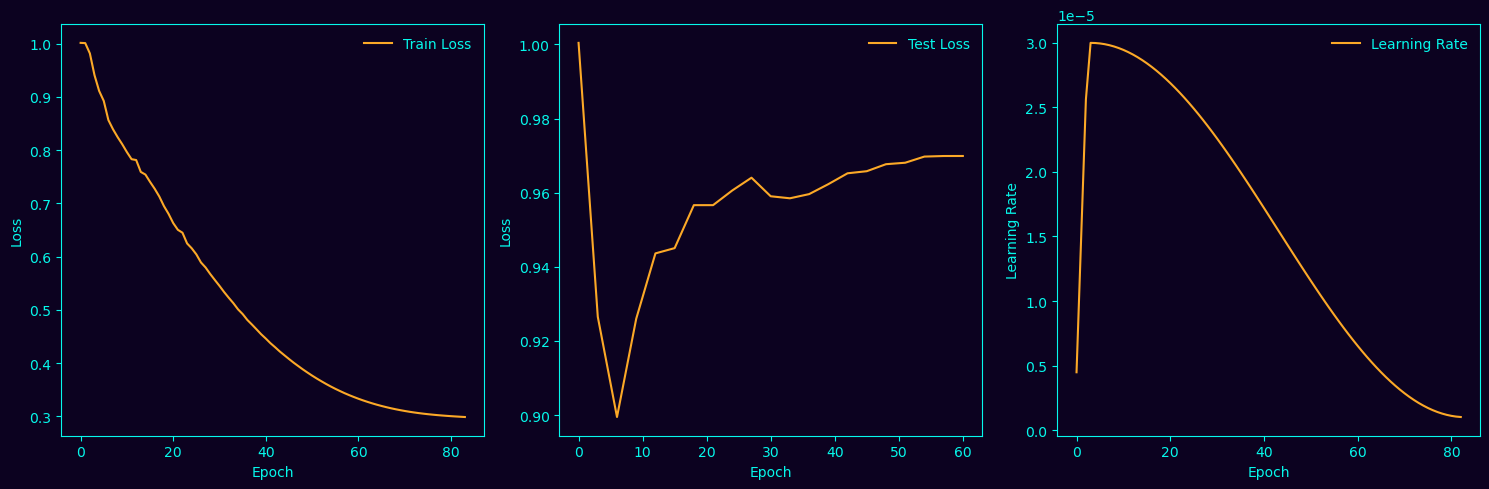

100%|██████████| 80/80 [01:46<00:00,  1.33s/it]


In [ ]:
with tqdm(total=train_epochs) as pbar:
    batch = 0
    
    for epoch in range(train_epochs):
        pbar.update(1)
        
        # training loop
        for current_segment, target in train_loader:
            batch += 1
            
            # move batch to gpu
            current_segment = current_segment.to(run_device)
            target = target.to(run_device)
            
            # train batch
            train_outputs = net(current_segment)
            train_loss_value = loss(train_outputs, target)
            train_loss_value.backward()
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
            
            if batch % optimizer_step_batches == 0:
                train_optimizer.step()
                train_optimizer.zero_grad()
            
            # collect performance metrics
            train_loss_graph.append(train_loss_value.item())
            
            # plot everything
            if batch % plot_batches == 0:
                if plot_graphs:
                    clear_output(wait=True)
                    
                    pbar.refresh()
                    
                    plt.figure(figsize=(15, 5), facecolor=background_color)

                    # Plot training loss
                    ax1 = plt.subplot(1, 3, 1, facecolor=background_color)
                    plt.plot(train_loss_graph, label='Train Loss', color=train_loss_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Loss', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax1.spines['top'].set_color(axis_color)
                    ax1.spines['bottom'].set_color(axis_color)
                    ax1.spines['left'].set_color(axis_color)
                    ax1.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax1.tick_params(axis='x', colors=axis_color)
                    ax1.tick_params(axis='y', colors=axis_color)

                    # Plot testing loss
                    ax2 = plt.subplot(1, 3, 2, facecolor=background_color)
                    plt.plot(range(0, len(test_loss_graph) * 3, 3), test_loss_graph, label='Test Loss', color=test_loss_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Loss', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax2.spines['top'].set_color(axis_color)
                    ax2.spines['bottom'].set_color(axis_color)
                    ax2.spines['left'].set_color(axis_color)
                    ax2.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax2.tick_params(axis='x', colors=axis_color)
                    ax2.tick_params(axis='y', colors=axis_color)

                    # Plot learning rate
                    ax3 = plt.subplot(1, 3, 3, facecolor=background_color)
                    plt.plot(learning_rate_graph, label='Learning Rate', color=lr_color)
                    plt.xlabel('Epoch', color=text_color)
                    plt.ylabel('Learning Rate', color=text_color)
                    plt.legend(facecolor=background_color, edgecolor='none', labelcolor=text_color)
                    # Set spines to white
                    ax3.spines['top'].set_color(axis_color)
                    ax3.spines['bottom'].set_color(axis_color)
                    ax3.spines['left'].set_color(axis_color)
                    ax3.spines['right'].set_color(axis_color)
                    # Set tick colors to white
                    ax3.tick_params(axis='x', colors=axis_color)
                    ax3.tick_params(axis='y', colors=axis_color)

                    # Adjust layout and show plot
                    plt.tight_layout()
                    plt.show()
                    
        # eval loop
        if epoch % test_loop_epoch == 0:
            with torch.no_grad():
                for test_current_segment, test_target in test_loader:
                    # move batch to gpu
                    test_current_segment = test_current_segment.to(run_device)
                    test_target = test_target.to(run_device)
                    
                    # run test
                    test_outputs = net(test_current_segment)
                    test_loss_value = loss(test_outputs, test_target)
                    
                    # collect performance metrics
                    test_loss_graph.append(test_loss_value.item())
        
        train_scheduler.step()
        
        # collect perforamce metrics
        learning_rate_graph.append(train_optimizer.param_groups[0]['lr'])

In [ ]:
net.eval()
clear_output()

In [ ]:
#torch.save(net.state_dict(), 'skibidiasidiss1234567890.pth')

In [ ]:
sentence = "human: i need something? network:".lower()

In [ ]:
"".join(predict_sequence(sentence, 80))[len(sentence):]

100%|██████████| 80/80 [00:00<00:00, 152.59it/s]


' a a routine a routine routine to routine routine routine a down a routine routine routine routine to Exerci let a a a routine slowly a a slowly a slowly summa these demo length gluco I coverage to routine a let routine a routine slowly routine slowly slowly routine sensation slowly routine a a sensation routine down a slowly a let a to a a slowly let routine to to stretch to to to let can slowly to routine let'

In [ ]:
devectorize_sentence(train_dataset[0][0].detach().cpu().numpy(), embeddings_model)

['m',
 ' offers',
 ' a',
 ' free',
 ' trial',
 ' that',
 ' last',
 's',
 ' for',
 ' seven',
 ' days',
 ',',
 ' during',
 ' which',
 ' you',
 ' can',
 ' access',
 ' their',
 ' guide',
 'd',
 ' meditation',
 's',
 ',',
 ' breath',
 'ing',
 ' exercise',
 's',
 ',',
 ' and',
 ' sleep',
 ' stories',
 '.',
 ' After',
 ' the',
 ' trial',
 ' period']